In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import shap
import warnings

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


# Chargement & Split

In [52]:
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv").iloc[:, 0]

# 2. Split (Avec stratify pour respecter les proportions)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f" Split terminé : Train={X_train.shape[0]} lignes, Test={X_test.shape[0]} lignes")

# --- FONCTION D'EVALUATION AUTOMATIQUE ---
def evaluer_modele(model, nom_modele):
    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print(f"\n{'='*40}")
    print(f" MODÈLE : {nom_modele}")
    print(f"{'='*40}")
    
    # Rapport Train (Pour voir l'Overfitting)
    print("\n--- PERFORMANCES SUR LE TRAIN (Apprentissage) ---")
    print(classification_report(y_train, y_pred_train))
    
    # Rapport Test (La vraie performance)
    print("\n--- PERFORMANCES SUR LE TEST (Réalité) ---")
    print(classification_report(y_test, y_pred_test))
    
    # Matrice de Confusion (Test uniquement, pour le visuel)
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matrice de Confusion - {nom_modele}")
    plt.ylabel("Réalité")
    plt.xlabel("Prédiction")
    plt.show()

print("fonction d'évaluation prête.")

 Split terminé : Train=1176 lignes, Test=294 lignes
fonction d'évaluation prête.


In [53]:
####################################################################################################################################################################


 MODÈLE : DUMMY (Référence Naïve)

--- PERFORMANCES SUR LE TRAIN (Apprentissage) ---
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       986
           1       0.00      0.00      0.00       190

    accuracy                           0.84      1176
   macro avg       0.42      0.50      0.46      1176
weighted avg       0.70      0.84      0.76      1176


--- PERFORMANCES SUR LE TEST (Réalité) ---
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       247
           1       0.00      0.00      0.00        47

    accuracy                           0.84       294
   macro avg       0.42      0.50      0.46       294
weighted avg       0.71      0.84      0.77       294



/Users/macbookdefii/Desktop/Uni/P4/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/macbookdefii/Desktop/Uni/P4/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/macbookdefii/Desktop/Uni/P4/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

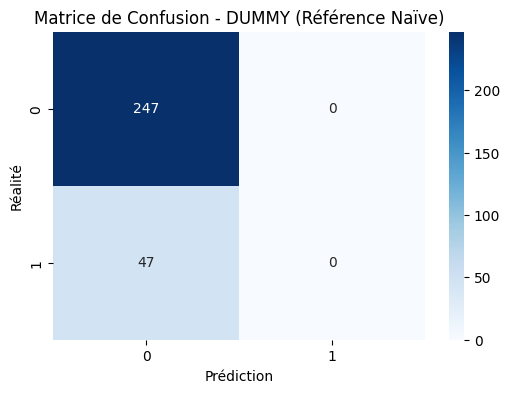

In [54]:
# Stratégie "most_frequent" : il prédit toujours 0 (Non partant)
modele_dummy = DummyClassifier(strategy="most_frequent")

evaluer_modele(modele_dummy, "DUMMY (Référence Naïve)")

In [55]:
####################################################################################################################################################################

Entraînement réussi ! Le modèle a convergé.

 MODÈLE : RÉGRESSION LOGISTIQUE (Linéaire)

--- PERFORMANCES SUR LE TRAIN (Apprentissage) ---
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       986
           1       0.84      0.41      0.55       190

    accuracy                           0.89      1176
   macro avg       0.87      0.70      0.74      1176
weighted avg       0.89      0.89      0.88      1176


--- PERFORMANCES SUR LE TEST (Réalité) ---
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       247
           1       0.70      0.34      0.46        47

    accuracy                           0.87       294
   macro avg       0.79      0.66      0.69       294
weighted avg       0.86      0.87      0.85       294



/Users/macbookdefii/Desktop/Uni/P4/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/macbookdefii/Desktop/Uni/P4/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-

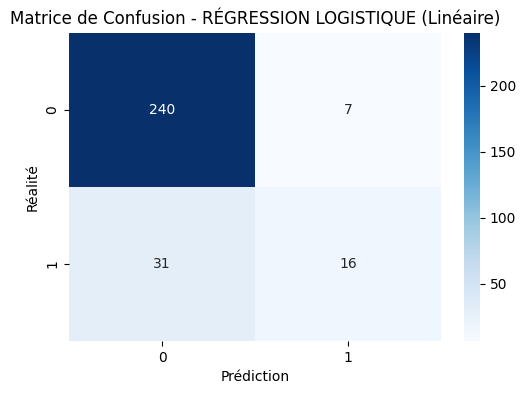

In [56]:
# 1. On prépare l'outil de mise à l'échelle
scaler = StandardScaler()

# 2. On transforme X : toutes les valeurs seront ramenées autour de 0
# (C'est crucial pour la Régression Logistique)
X_scaled = scaler.fit_transform(X)

# 3. On entraîne le modèle sur ces nouvelles données "propres"
# Avec les données scalées, même 1000 itérations suffisent souvent, 
# mais on laisse 5000 pour être tranquille.
model = LogisticRegression(max_iter=5000) 
model.fit(X_scaled, y)

print("Entraînement réussi ! Le modèle a convergé.")
# max_iter augmenté pour assurer la convergence
model = LogisticRegression(max_iter=5000) 
model.fit(X, y)
evaluer_modele(modele_lr, "RÉGRESSION LOGISTIQUE (Linéaire)")

In [57]:
####################################################################################################################################################################


 MODÈLE : RANDOM FOREST (Non-Linéaire)

--- PERFORMANCES SUR LE TRAIN (Apprentissage) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       986
           1       1.00      1.00      1.00       190

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176


--- PERFORMANCES SUR LE TEST (Réalité) ---
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       247
           1       0.38      0.11      0.17        47

    accuracy                           0.83       294
   macro avg       0.62      0.54      0.54       294
weighted avg       0.78      0.83      0.79       294



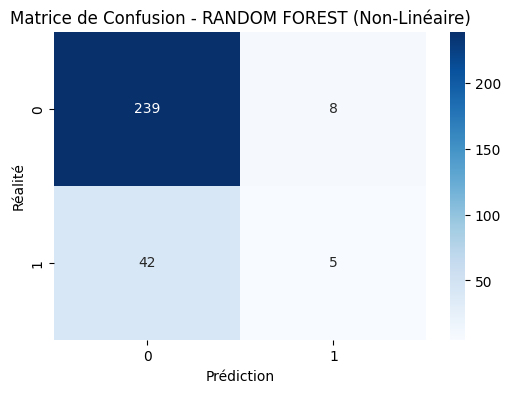

In [58]:
# On utilise 100 arbres par défaut
modele_rf = RandomForestClassifier(n_estimators=100, random_state=42)

evaluer_modele(modele_rf, "RANDOM FOREST (Non-Linéaire)")

sur-apprentissage massif (100% train / 9% test)

In [59]:
####################################################################################################################################################################


 MODÈLE : GRADIENT BOOSTING (XGBoost style)

--- PERFORMANCES SUR LE TRAIN (Apprentissage) ---
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       986
           1       1.00      0.72      0.84       190

    accuracy                           0.95      1176
   macro avg       0.97      0.86      0.91      1176
weighted avg       0.96      0.95      0.95      1176


--- PERFORMANCES SUR LE TEST (Réalité) ---
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       247
           1       0.59      0.21      0.31        47

    accuracy                           0.85       294
   macro avg       0.73      0.59      0.61       294
weighted avg       0.82      0.85      0.82       294



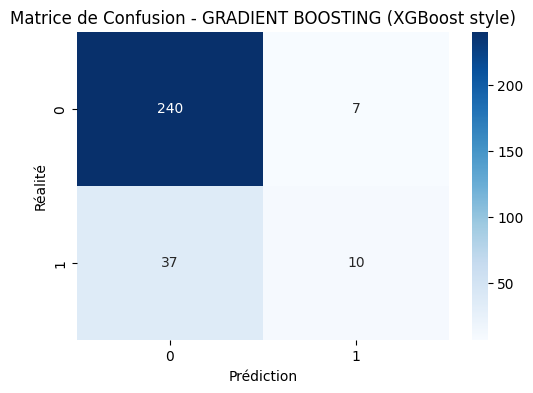

In [60]:

# 1. Configuration du modèle
# On garde des arbres petits (max_depth=3) pour éviter l'overfitting
modele_gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# 2. Évaluation avec notre fonction automatique
evaluer_modele(modele_gb, "GRADIENT BOOSTING (XGBoost style)")

## Principales causes de départ par ordre d'importance

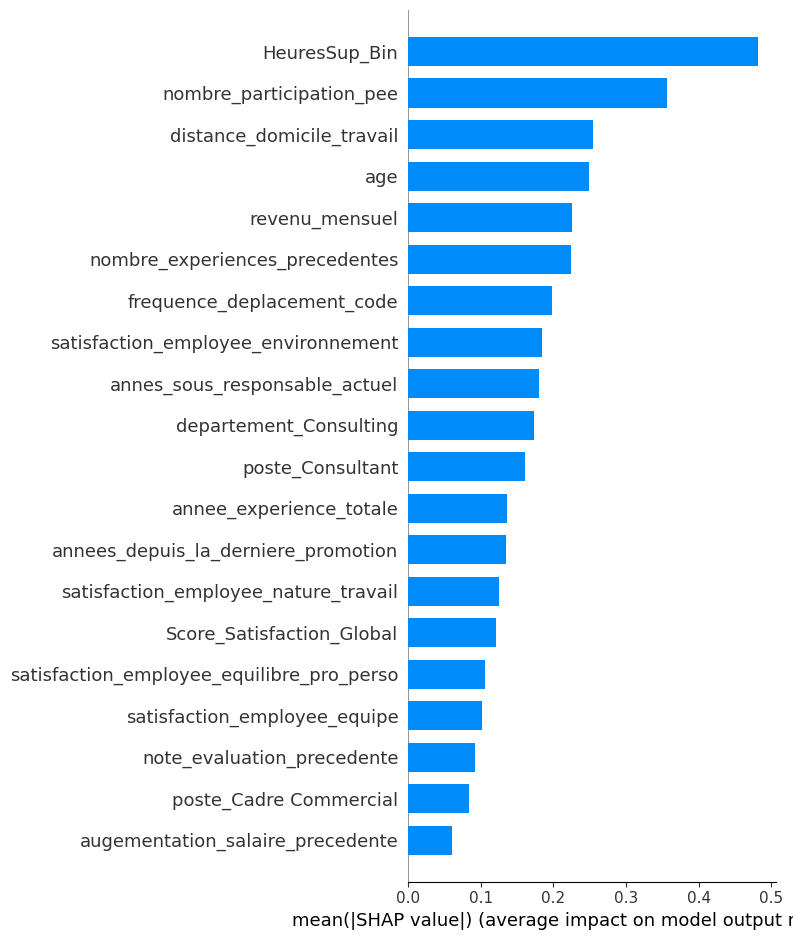

 Ce graphique montre le Top des causes de départ par ordre d'importance.


<Figure size 640x480 with 0 Axes>

In [61]:

# 1. On choisit le modèle qu'on veut expliquer (Ici le Gradient Boosting, ou mettez modele_rf_optimise)
modele_final = modele_gb 

# 2. Création de l'explainer SHAP
# Pour les modèles à base d'arbres (Forest, XGBoost...), on utilise TreeExplainer
explainer = shap.TreeExplainer(modele_final)

# 3. Calcul des valeurs SHAP (Cela peut prendre quelques secondes)
shap_values = explainer.shap_values(X_test)

# 4. Visualisation Globale (Le "Beeswarm Plot")
plt.figure(figsize=(10, 6))
# Note : Pour les problèmes binaires, shap_values peut être une liste. On prend l'indice 1 (Classe Départ)
if isinstance(shap_values, list):
    vals = shap_values[1]
else:
    vals = shap_values

shap.summary_plot(vals, X_test, plot_type="bar")
# bbox_inches='tight' est crucial ici pour ne pas couper les textes longs à gauche
plt.savefig("matrice_importance.png", dpi=300, bbox_inches='tight')
print(" Ce graphique montre le Top des causes de départ par ordre d'importance.")

 Optimisation du Random Forest pour réduire l'overfitting...

 MODÈLE : RANDOM FOREST (Régularisé)

--- PERFORMANCES SUR LE TRAIN (Apprentissage) ---
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       986
           1       0.84      0.91      0.87       190

    accuracy                           0.96      1176
   macro avg       0.91      0.94      0.92      1176
weighted avg       0.96      0.96      0.96      1176


--- PERFORMANCES SUR LE TEST (Réalité) ---
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       247
           1       0.40      0.30      0.34        47

    accuracy                           0.82       294
   macro avg       0.64      0.61      0.62       294
weighted avg       0.80      0.82      0.81       294



<Figure size 640x480 with 0 Axes>

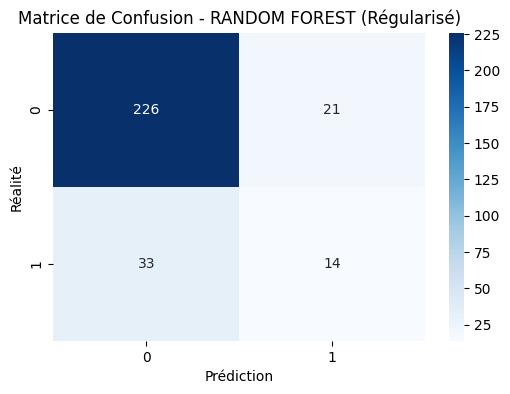

In [62]:
# --- OPTIMISATION FINALE (problème d'Overfitting) ---

print(" Optimisation du Random Forest pour réduire l'overfitting...")

modele_final = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,        # on limite la profondeur 
    min_samples_leaf=5,  # on force des groupes d'au moins 5 personnes
    class_weight='balanced', # on donne plus de poids aux démissionnaires
    random_state=42
)
# bbox_inches='tight' est crucial ici pour ne pas couper les textes longs à gauche
plt.savefig("matrice_confusion_RF.png", dpi=300, bbox_inches='tight')
evaluer_modele(modele_final, "RANDOM FOREST (Régularisé)")

<Figure size 1000x600 with 0 Axes>

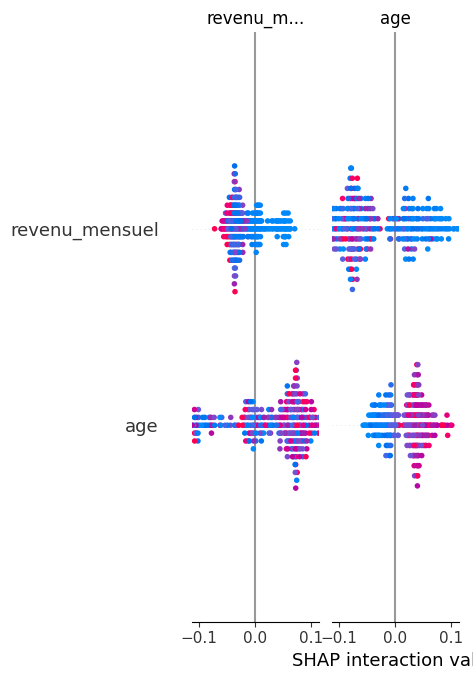

 Ce graphique montre le Top des causes de départ par ordre d'importance.


<Figure size 640x480 with 0 Axes>

In [63]:
import shap


# 2. Création de l'explainer SHAP
# Pour les modèles à base d'arbres (Forest, XGBoost...), on utilise TreeExplainer
explainer = shap.TreeExplainer(modele_final)

# 3. Calcul des valeurs SHAP (Cela peut prendre quelques secondes)
shap_values = explainer.shap_values(X_test)

# 4. Visualisation Globale (Le "Beeswarm Plot")
plt.figure(figsize=(10, 6))
# Note : Pour les problèmes binaires, shap_values peut être une liste. On prend l'indice 1 (Classe Départ)
if isinstance(shap_values, list):
    vals = shap_values[1]
else:
    vals = shap_values

shap.summary_plot(vals, X_test, plot_type="bar")

# bbox_inches='tight' est crucial ici pour ne pas couper les textes longs à gauche
plt.savefig("cause_importance.png", dpi=300, bbox_inches='tight')
print(" Ce graphique montre le Top des causes de départ par ordre d'importance.")

In [64]:
!uv add imbalanced-learn

Resolved 125 packages in 3ms
Audited 121 packages in 17ms


In [65]:
import imblearn
print(f" imblearn version {imblearn.__version__} est installé !")

 imblearn version 0.14.0 est installé !


In [66]:
# Librairies ML classiques
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve

# Librairies pour le déséquilibre (SMOTE)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [67]:
# 1. CHARGEMENT
try:
    X = pd.read_csv("X.csv")
    y = pd.read_csv("y.csv").iloc[:, 0]
    print(f" Données chargées : {X.shape}")
except FileNotFoundError:
    print(" Erreur : X.csv et y.csv introuvables.")

# 2. SPLIT STRATIFIÉ (Gardons 20% pour le test final)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. FONCTION DE VALIDATION CROISÉE (Le juge de paix)
def evaluer_strategie(modele, nom, X, y):
    # On découpe en 5 parties, en gardant les proportions de départs (Stratified)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # On mesure tout d'un coup
    scoring = ['accuracy', 'recall', 'precision', 'f1']
    scores = cross_validate(modele, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    # Affichage des résultats Moyenne +/- Ecart-type
    print(f"\n{'='*40}")
    print(f" STRATÉGIE : {nom}")
    print(f"{'='*40}")
    print(f"Rappel (Recall)    : {scores['test_recall'].mean():.2%}\t (+/- {scores['test_recall'].std():.2%})")
    print(f"Précision          : {scores['test_precision'].mean():.2%}\t (+/- {scores['test_precision'].std():.2%})")
    print(f"F1-Score           : {scores['test_f1'].mean():.2%}")
    
    return scores

 Données chargées : (1470, 45)


In [68]:
# --- STRATEGIE A :  (Class Weights) ---
# on force le modèle à faire attention à la classe 1.
rf_weighted = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10, 
    min_samples_leaf=5,
    class_weight='balanced', 
    random_state=42
)

scores_weighted = evaluer_strategie(rf_weighted, "Random Forest (Weighted)", X_train, y_train)


# --- STRATÉGIE B : GENERATION DE DONNÉES (SMOTE) ---
# Attention : On utilise un Pipeline pour que le SMOTE ne se fasse QUE sur le Train du Cross-Validation
pipeline_smote = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=42))
])

scores_smote = evaluer_strategie(pipeline_smote, "Random Forest + SMOTE", X_train, y_train)


 STRATÉGIE : Random Forest (Weighted)
Rappel (Recall)    : 36.32%	 (+/- 9.02%)
Précision          : 57.78%	 (+/- 6.97%)
F1-Score           : 43.95%

 STRATÉGIE : Random Forest + SMOTE
Rappel (Recall)    : 41.05%	 (+/- 10.86%)
Précision          : 49.96%	 (+/- 13.47%)
F1-Score           : 44.84%


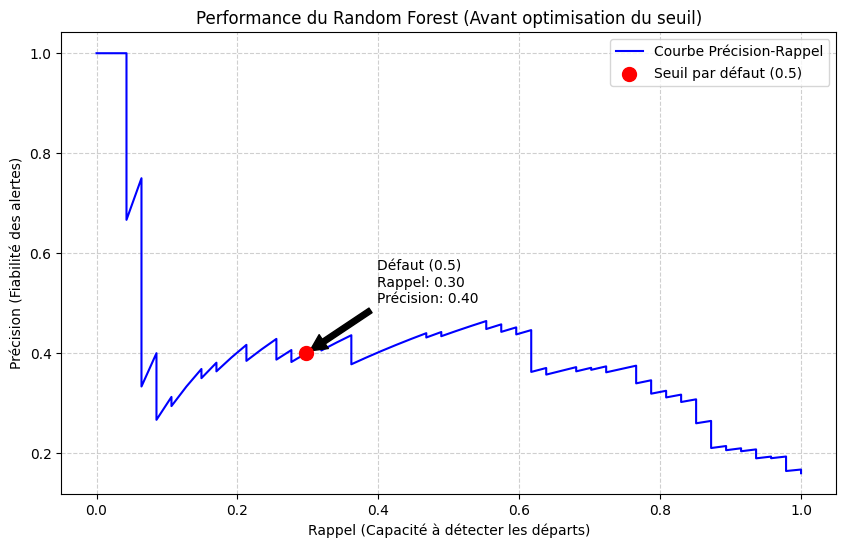

In [69]:
# 1. On reprend le modèle gagnant (Random Forest Weighted)
# (On s'assure qu'il est bien entraîné sur le train set)
model_to_test = rf_weighted 
model_to_test.fit(X_train, y_train)

# 2. On récupère les PROBABILITÉS de départ (Score entre 0 et 1)
# Attention : on prend la colonne [:, 1] pour avoir la probabilité de la classe 1 (Départ)
y_scores = model_to_test.predict_proba(X_test)[:, 1]

# 3. Calcul des métriques pour tous les seuils possibles
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# 4. Identification du point "Par défaut" (Seuil = 0.5)
# On cherche l'index du seuil le plus proche de 0.5
close_default_index = np.argmin(np.abs(thresholds - 0.5))
precision_default = precisions[close_default_index]
recall_default = recalls[close_default_index]

# 5. Affichage de la Courbe
plt.figure(figsize=(10, 6))

# La courbe bleue
plt.plot(recalls, precisions, label='Courbe Précision-Rappel', color='blue')

# Le point rouge (Configuration par défaut)
plt.scatter(recall_default, precision_default, color='red', s=100, label='Seuil par défaut (0.5)', zorder=5)

# Décoration
plt.title("Performance du Random Forest (Avant optimisation du seuil)")
plt.xlabel("Rappel (Capacité à détecter les départs)")
plt.ylabel("Précision (Fiabilité des alertes)")
plt.legend()
plt.grid(linestyle='--', alpha=0.6)

# On ajoute une annotation textuelle pour bien montrer le score actuel
plt.annotate(f'Défaut (0.5)\nRappel: {recall_default:.2f}\nPrécision: {precision_default:.2f}',
             xy=(recall_default, precision_default), 
             xytext=(recall_default+0.1, precision_default+0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))
# bbox_inches='tight' est crucial ici pour ne pas couper les textes longs à gauche
plt.savefig("reppel.png", dpi=300, bbox_inches='tight')
plt.show()

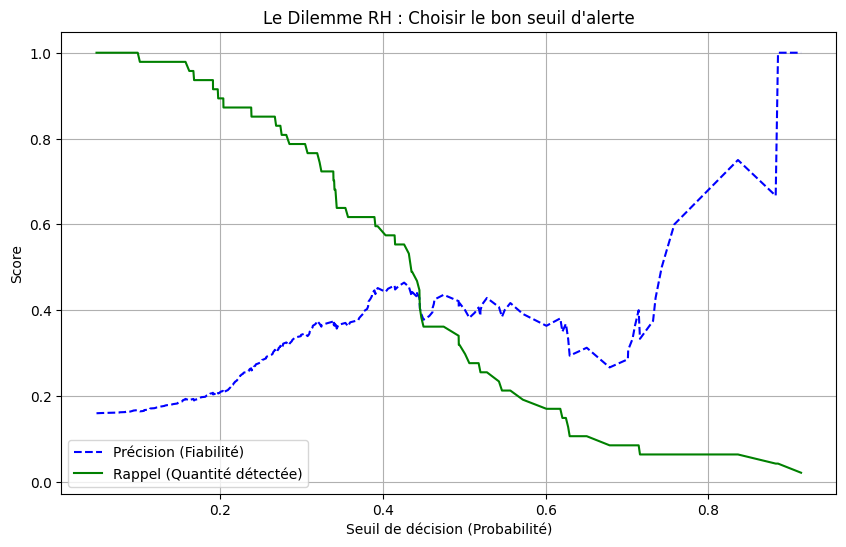


--- PERFORMANCE AVEC SEUIL PERSONNALISÉ (0.4) ---
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       247
           1       0.44      0.57      0.50        47

    accuracy                           0.82       294
   macro avg       0.68      0.72      0.69       294
weighted avg       0.84      0.82      0.83       294



<Figure size 640x480 with 0 Axes>

In [70]:
# 1. On entraîne le meilleur modèle sur tout le Train 
meilleur_modele = rf_weighted
meilleur_modele.fit(X_train, y_train)

# 2. On récupère les PROBABILITE (Pas juste 0 ou 1, mais le % de risque)
y_probs = meilleur_modele.predict_proba(X_test)[:, 1]

# 3. Calcul de la courbe
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# 4. Affichage Graphique
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Précision (Fiabilité)")
plt.plot(thresholds, recalls[:-1], "g-", label="Rappel (Quantité détectée)")
plt.xlabel("Seuil de décision (Probabilité)")
plt.ylabel("Score")
plt.title("Le Dilemme RH : Choisir le bon seuil d'alerte")
plt.legend()
plt.grid()
plt.show()

# 5. Simulation Business
# on descende le seuil à 0.4 (40%)
seuil_choisi = 0.4
y_pred_business = (y_probs >= seuil_choisi).astype(int)

print(f"\n--- PERFORMANCE AVEC SEUIL PERSONNALISÉ ({seuil_choisi}) ---")
print(classification_report(y_test, y_pred_business))

# bbox_inches='tight' est crucial ici pour ne pas couper les textes longs à gauche
plt.savefig("performance_seil_persinnalise.png", dpi=300, bbox_inches='tight')

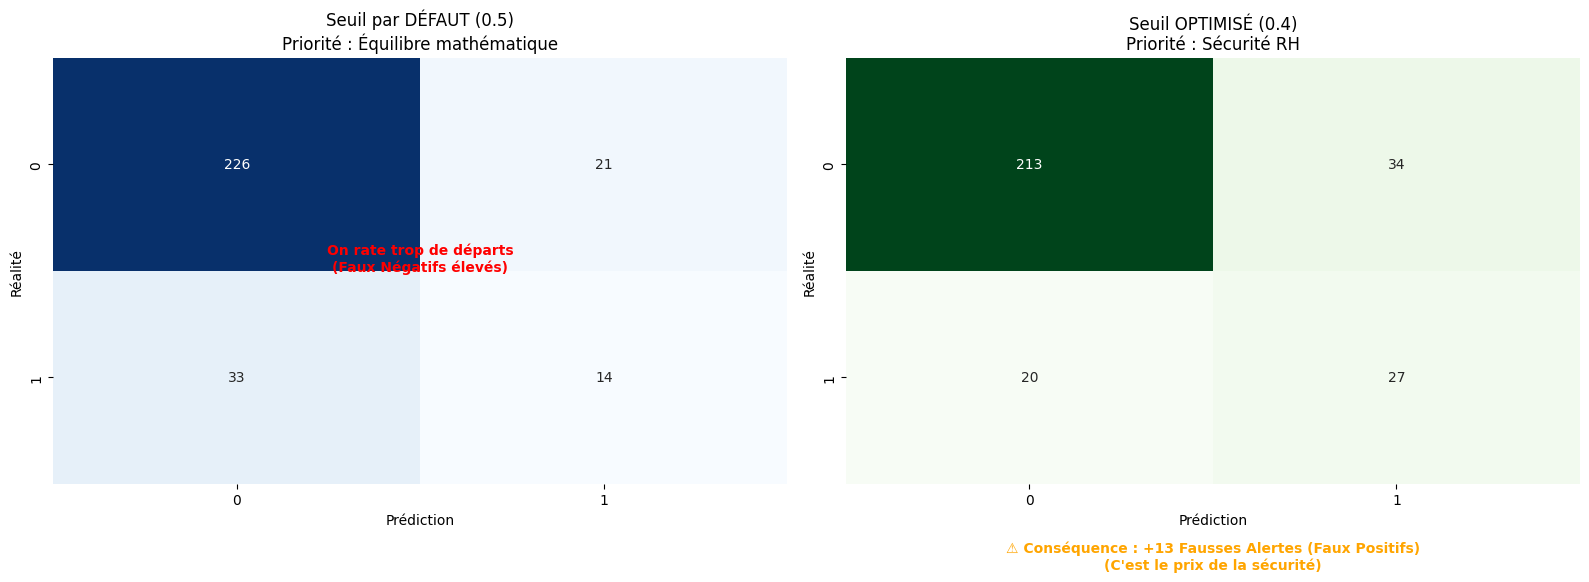

In [71]:
# --- COMPARAISON VISUELLE : DÉFAUT (0.5) vs VOTRE CHOIX (0.4) ---

# 1. On calcule les prédictions pour les deux cas
y_pred_defaut = (y_probs >= 0.5).astype(int)       # Seuil classique
y_pred_opti   = (y_probs >= 0.4).astype(int)       # Votre seuil optimisé

# 2. On prépare l'affichage côte à côte
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# --- GRAPHIQUE 1 : SEUIL 0.5 (Défaut) ---
cm_defaut = confusion_matrix(y_test, y_pred_defaut)
sns.heatmap(cm_defaut, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax[0])
ax[0].set_title("Seuil par DÉFAUT (0.5)\nPriorité : Équilibre mathématique")
ax[0].set_xlabel("Prédiction")
ax[0].set_ylabel("Réalité")
ax[0].text(0.5, 0.5, "On rate trop de départs\n(Faux Négatifs élevés)", 
           horizontalalignment='center', color='red', weight='bold', transform=ax[0].transAxes)

# --- GRAPHIQUE 2 : SEUIL 0.4 (Optimisé) ---
cm_opti = confusion_matrix(y_test, y_pred_opti)
sns.heatmap(cm_opti, annot=True, fmt='d', cmap='Greens', cbar=False, ax=ax[1])
ax[1].set_title("Seuil OPTIMISÉ (0.4)\nPriorité : Sécurité RH")
ax[1].set_xlabel("Prédiction")
ax[1].set_ylabel("Réalité")

# Calcul de l'augmentation des Faux Positifs (Ce que le mentor a souligné)
fp_augmentation = cm_opti[0][1] - cm_defaut[0][1]
ax[1].text(0.5, -0.2, f"⚠️ Conséquence : +{fp_augmentation} Fausses Alertes (Faux Positifs)\n(C'est le prix de la sécurité)", 
           horizontalalignment='center', color='orange', weight='bold', transform=ax[1].transAxes)

plt.tight_layout()
# bbox_inches='tight' est crucial ici pour ne pas couper les textes longs à gauche
plt.savefig("comparaison_iseuil.png", dpi=300, bbox_inches='tight')
plt.show()

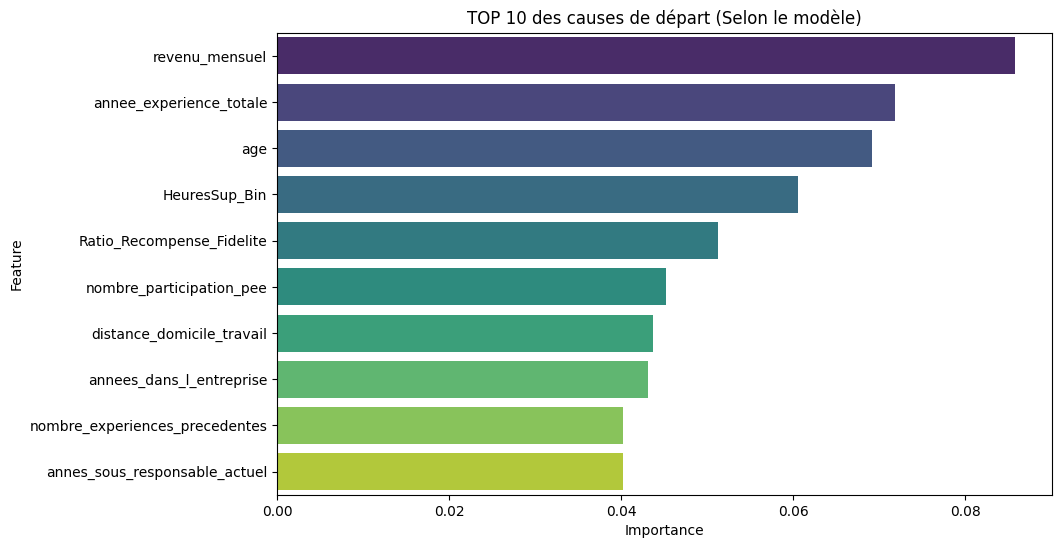

In [72]:

# Récupération de l'importance des features du modèle Random Forest (sans pipeline pour simplifier l'accès)
# Si votre meilleur modèle est 'rf_weighted' :
importances = rf_weighted.feature_importances_
feature_names = X_train.columns

# Création d'un DataFrame pour le graphique
df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
df_importance = df_importance.sort_values(by='Importance', ascending=False).head(10) # Top 10

# Graphique
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_importance, palette='viridis')
plt.title("TOP 10 des causes de départ (Selon le modèle)")
# bbox_inches='tight' est crucial ici pour ne pas couper les textes longs à gauche
plt.savefig("top_depart.png", dpi=300, bbox_inches='tight')
plt.show()
warnings.simplefilter(action='ignore', category=FutureWarning)


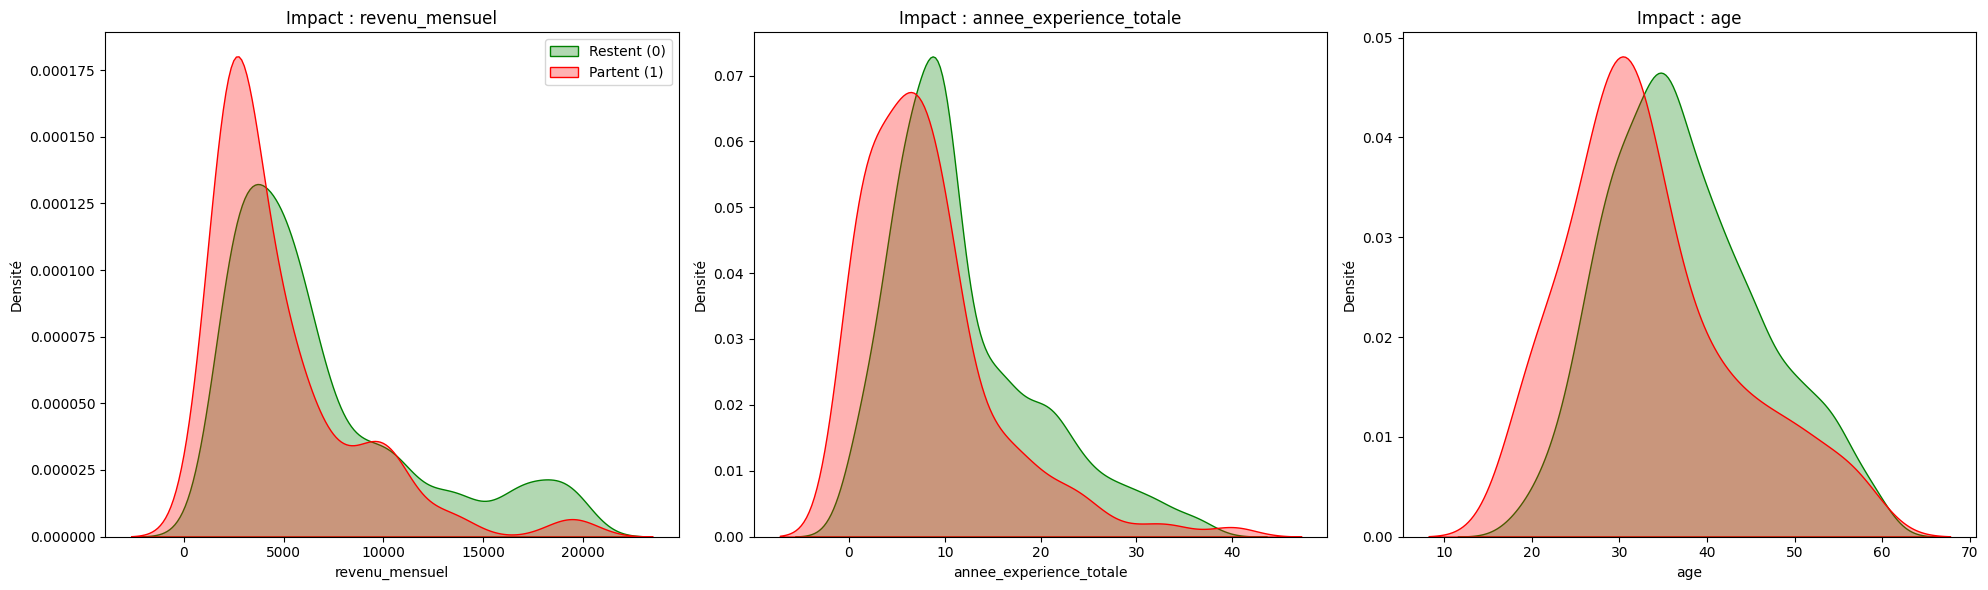

In [73]:
# 1. PRÉPARATION : On recolle les morceaux (X + y) pour le graphique
# (On utilise X et y qui sont déjà chargés dans votre mémoire)
df_visu = X.copy()
df_visu['Attrition_Numerique'] = y

# 2. LES 3 VARIABLES À ANALYSER (Vos Top Features)
# Vérifiez bien l'orthographe exacte des colonnes dans votre fichier X.csv
features_top3 = ['revenu_mensuel', 'annee_experience_totale', 'age']

# 3. CRÉATION DU GRAPHIQUE (3 courbes côte à côte)
plt.figure(figsize=(20, 6))

for i, col in enumerate(features_top3):
    # On crée une sous-figure (1 ligne, 3 colonnes)
    plt.subplot(1, 3, i + 1)
    
    # Vérification de sécurité : la colonne existe-t-elle ?
    if col in df_visu.columns:
        # Courbe VERTE : Ceux qui Restent (0)
        sns.kdeplot(
            data=df_visu[df_visu['Attrition_Numerique'] == 0], 
            x=col, 
            fill=True, 
            color='green', 
            label='Restent (0)',
            alpha=0.3
        )
        
        # Courbe ROUGE : Ceux qui Partent (1)
        sns.kdeplot(
            data=df_visu[df_visu['Attrition_Numerique'] == 1], 
            x=col, 
            fill=True, 
            color='red', 
            label='Partent (1)',
            alpha=0.3
        )
        
        plt.title(f"Impact : {col}")
        plt.xlabel(col)
        plt.ylabel("Densité")
        if i == 0: plt.legend() # Légende seulement sur le 1er graphique
        
    else:
        plt.text(0.5, 0.5, f"Colonne '{col}' introuvable\nVérifiez le nom !", 
                 horizontalalignment='center', verticalalignment='center')

plt.tight_layout()
plt.show()

Données rechargées pour la visualisation.


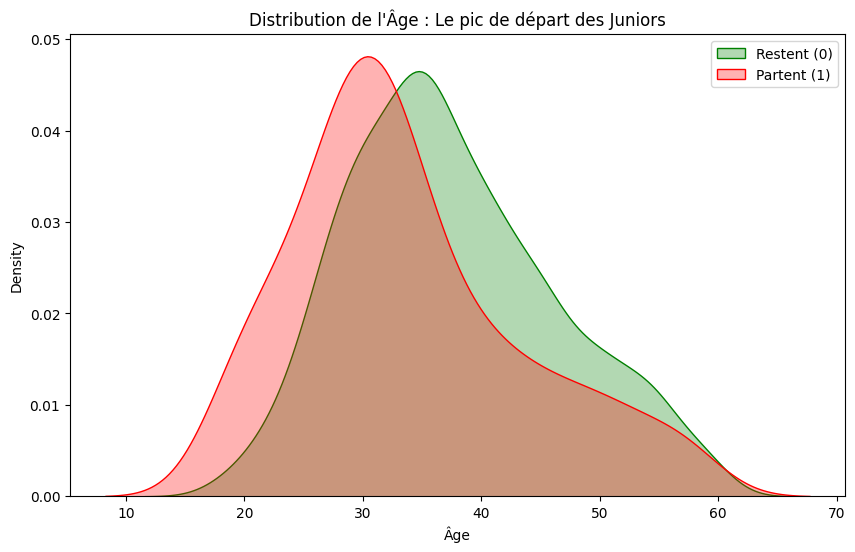

In [74]:
# 1. On recharge le fichier complet "propre" pour l'analyse visuelle
try:
    df_visu = pd.read_csv("data_clean.csv")
    print("Données rechargées pour la visualisation.")
except FileNotFoundError:
    # Plan B : Si le fichier n'est pas là, on le reconstruit avec X et y
    df_visu = X.copy()
    df_visu['Attrition_Numerique'] = y
    print(" 'data_clean.csv' introuvable. Reconstruction depuis X et y.")

# 2. Le Graphique de distribution de l'âge
plt.figure(figsize=(10, 6))

# Courbe des FIDÈLES (0) en Vert
sns.kdeplot(
    data=df_visu[df_visu['Attrition_Numerique'] == 0], 
    x='age', 
    fill=True, 
    color='green', 
    label='Restent (0)', 
    alpha=0.3
)

# Courbe des DÉMISSIONNAIRES (1) en Rouge
sns.kdeplot(
    data=df_visu[df_visu['Attrition_Numerique'] == 1], 
    x='age', 
    fill=True, 
    color='red', 
    label='Partent (1)', 
    alpha=0.3
)

plt.title("Distribution de l'Âge : Le pic de départ des Juniors")
plt.xlabel("Âge")
plt.legend()
plt.show()